<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Финальный-комментарий" data-toc-modified-id="Финальный-комментарий-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><span style="color: green">Финальный комментарий<span></span></span></a></span></li><li><span><a href="#Комментарий-ревьювера" data-toc-modified-id="Комментарий-ревьювера-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Комментарий ревьювера</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-комментарий" data-toc-modified-id="Общий-комментарий-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий комментарий</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
RANDOM_STATE = 42
TEST_SIZE = 0.1

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('D:/Yandex/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# Чтобы работать с временными рядами, необходимо проверить, в хронологическом ли порядке расположены даты и время
data.sort_index(inplace=True)
print(data.index.is_monotonic)
data.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
# Ресемплирование
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
# Создание признаков
def make_features(data, max_lag, rolling_mean_size):
    result = data.copy()
    result['dayofweek'] = data.index.dayofweek
    result['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        result['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    result['rolling_mean'] = data['num_orders'].shift().\
    rolling(rolling_mean_size).mean()
    return result

In [9]:
data_plus = make_features(data, 2, 24)
data_plus

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,168.041667


- данные прочитаны, в качестве индекса мы установили признак datetime и изменили тип данных datetime с object на datetime64;
- выполнено ресемплирование данных по одному часу;
- созданы новые признаки: календарные признаки (день недели и час), отстающие значения, скользящее среднее.

## Анализ

Тренд

In [10]:
decomposed_day = seasonal_decompose(data.resample('1D').sum())

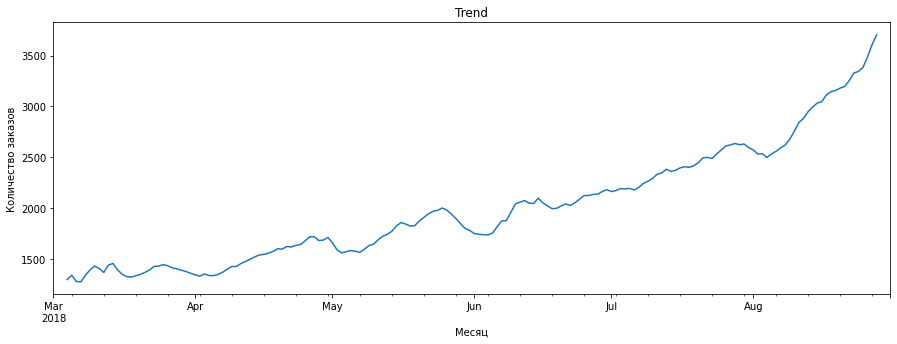

In [11]:
plt.figure(figsize=(15, 5))
decomposed_day.trend.plot(title='Trend')
plt.xlabel("Месяц")
plt.ylabel('Количество заказов')
plt.show()

На графике хорошо прослеживается рост числа заказов такси в аэропорт за полгода.

Сезонность

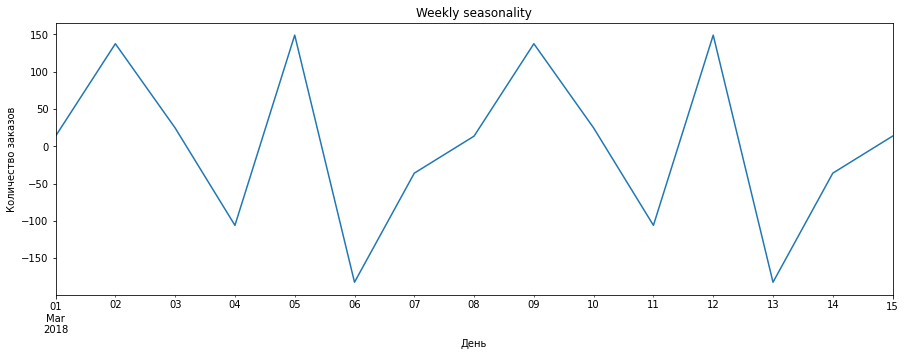

In [12]:
plt.figure(figsize=(15, 5))
decomposed_day.seasonal['2018-03-01':'2018-03-15'].plot(title='Weekly seasonality')
plt.xlabel("День")
plt.ylabel('Количество заказов')
plt.show()

Здесь видны пики во вторник и пятницу. То есть больше всего заказов такси в аэропорт приходится на начало и конец рабочей недели.

In [13]:
decomposed_hour = seasonal_decompose(data)

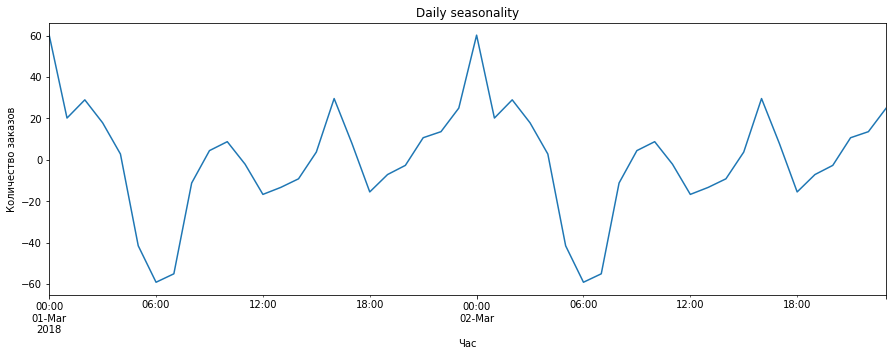

In [14]:
plt.figure(figsize=(15, 5))
decomposed_hour.seasonal['2018-03-01':'2018-03-2'].plot(title='Daily seasonality')
plt.xlabel("Час")
plt.ylabel('Количество заказов')
plt.show()

На графике видно, что самое непопулярное время - 6:00. Затем в течение дня наблюдаются несколько пиков: в 10:00 в 16:00 и самое загруженное время - в 00:00.

- в течение всего полугодового периода с 1 марта по 31 августа 2018 года прослеживается рост числа заказов такси в аэропорт;
- в пределах недели: больше всего заказов такси в аэропорт приходится на вторник и пятницу;
- в пределах дня: самое непопулярное время - 6:00. Затем в течение дня наблюдаются несколько пиков: в 10:00 в 16:00 и самое загруженное время - в 00:00.

## Обучение

In [15]:
# Разделим данных на выборки
data_plus.dropna(inplace=True)
X = data_plus.drop('num_orders', axis=1)
y = data_plus['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=TEST_SIZE)

In [16]:
print('Размеры выборок:')
print(f'train: {len(X_train)} - {len(X_train)/len(data):.0%}')
print(f'test: {len(X_test)} - {len(X_test)/len(data):.0%}')

Размеры выборок:
train: 3952 - 89%
test: 440 - 10%


In [17]:
# Функция для обучения моделей
tscv = TimeSeriesSplit(n_splits=4)

In [18]:
def fit_model(estimator, param_grid, X_train, y_train):
    model = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=tscv, scoring='neg_root_mean_squared_error')
    model.fit(X_train, y_train)
    best_rmse = abs(round(model.best_score_, 1))
    print(f'Best RMSE: {best_rmse}')
    print(f'Best params: {model.best_params_}')
    return model.best_estimator_, best_rmse

In [19]:
# LinearRegression
lr_estimator = Pipeline([('lr', LinearRegression())])
scores = cross_val_score(lr_estimator, X_train, y_train, scoring='neg_root_mean_squared_error', cv=tscv)
rmse_lr = abs(scores.mean())
print(f'RMSE: {rmse_lr:.1f}')

RMSE: 32.1


In [20]:
# RandomForestRegressor
rf_param_grid = {'max_depth': list(range(5, 12, 2)), 'n_estimators': list(range(50, 121, 10))}
rf_best_model = fit_model(estimator=RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_param_grid, X_train=X_train, y_train=y_train)

Best RMSE: 26.5
Best params: {'max_depth': 11, 'n_estimators': 120}


In [21]:
# LGBMRegressor
lgbm_param_grid = {'max_depth': range(4, 9, 2), 'n_estimators': range(100, 201, 50), 'learning_rate': [0.01, 0.05, 0.1]}
lgbm_best_model = fit_model(estimator=LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1), 
                            param_grid=lgbm_param_grid, X_train=X_train, y_train=y_train)

Best RMSE: 26.0
Best params: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}


In [22]:
# CatBoostRegressor
catboost_param_grid = {'depth': range(2, 12, 3), 'iterations': range(250, 301, 50), 'learning_rate': [0.05, 0.1, 0.15], }
catboost_best_model = fit_model(estimator=CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, allow_writing_files=False),
    param_grid=catboost_param_grid, X_train=X_train, y_train=y_train)

Best RMSE: 26.4
Best params: {'depth': 2, 'iterations': 250, 'learning_rate': 0.15}


In [23]:
# Сравнение моделей
table = pd.DataFrame([['LinearRegression', f'{rmse_lr:.1f}'], ['RandomForestRegressor', f'{rf_best_model[1]:.1f}'], 
                      ['LGBMRegressor', f'{lgbm_best_model[1]:.1f}'], ['CatBoostRegressor', f'{catboost_best_model[1]:.1f}']],
columns=['model', 'RMSE'])
table

,model,RMSE
0,LinearRegression,32.1
1,RandomForestRegressor,26.5
2,LGBMRegressor,26.0
3,CatBoostRegressor,26.4


Лучшая модель градиентного бустинга LGBMRegressor на обучающей выборке имеет значение метрики оценки качества *RMSE = 26.0* при следующих параметрах:
глубина дерева: max_depth = 8;
количество деревьев (итераций): n_estimators = 100;
коэффициент скорости обучения (размер шага градиентного спуска): learning_rate = 0.05.

## Тестирование

In [24]:
# Проверим качесто выбранной модели градиентного бустинга LGBMRegressor на тестовой выборке
pred = lgbm_best_model[0].predict(X_test)
# параметр squared=False возвращает метрику RMSE
rmse = mean_squared_error(y_test, pred, squared=False) 
print(f'RMSE на тестовой выборке: {rmse:.1f}')

RMSE на тестовой выборке: 44.8


- лучшая модель градиентного бустинга LGBMRegressor на тестовой выборке имеет значение метрики оценки качества *RMSE = 44.8*;
- значение метрики *RMSE* на тестовой выборке не превышает *48*, что соответствует изначальному требованию в условии задачи проекта

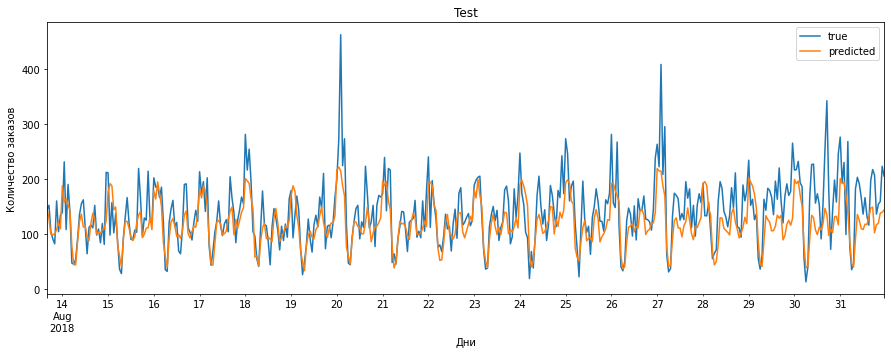

In [25]:
pred = pd.Series(pred, index=y_test.index)
plt.figure(figsize=(15, 5))
y_test.plot(label='true', title='Test')
pred.plot(label='predicted')
plt.legend()
plt.xlabel("Дни")
plt.ylabel('Количество заказов')
plt.show()

<hr style="border: 2px solid green;" />

## Общий комментарий
Спасибо за проделанную работу🤝

Виктор, проект выполнен хорошо, тебе удалось построить качественную модель👌

Осталось визуализировать график прогноз-факт

Исправляй и отправляй на проверку🛠